Try running:
from transformers import AutoConfig, AutoModelForSequenceClassification

In [ ]:
import sklearn
from gensim.models import Word2Vec
import gensim

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.6 MB 6.9 MB/s 
     |████████████████████████████████| 895 kB 57.5 MB/s 
     |████████████████████████████████| 3.3 MB 64.0 MB/s 
     |████████████████████████████████| 636 kB 53.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install swifter

     |████████████████████████████████| 296 kB 6.8 MB/s 
     |████████████████████████████████| 118 kB 73.1 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
# Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoConfig, AutoModelForSequenceClassification
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk

from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import swifter

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# file path for SigmaLaw-ABSA dataset
# find the dataset located online at https://osf.io/efrqt/
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/SigmaLaw-ABSA.csv')
df.head()

,Sentence,Party,Sentiment,Overall Sentiment
0,Petitioner Jae Lee moved to the United States ...,"[[Petitioner Jae Lee,his,he],[]]","[[0,0,0],[]]",0
1,"In the 35 years he has spent in this country, ...","[[he_1,he_2,he_3],[]]","[[0,0,0],[]]",0
2,"In the 35 years he has spent in this country, ...","[[he_1,he_2],[]]","[[0,0],[]]",0
3,In the 35 years he has spent in this country,"[[he],[]]","[[0],[]]",0
4,"In 2008, federal officials received a tip from...","[[lee],[federal officials]]","[[-1],[1]]",-1


In [ ]:
df.shape

(2000, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Sentence           2000 non-null   object
 1   Party              2000 non-null   object
 2   Sentiment          2000 non-null   object
 3   Overall Sentiment  2000 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 62.6+ KB


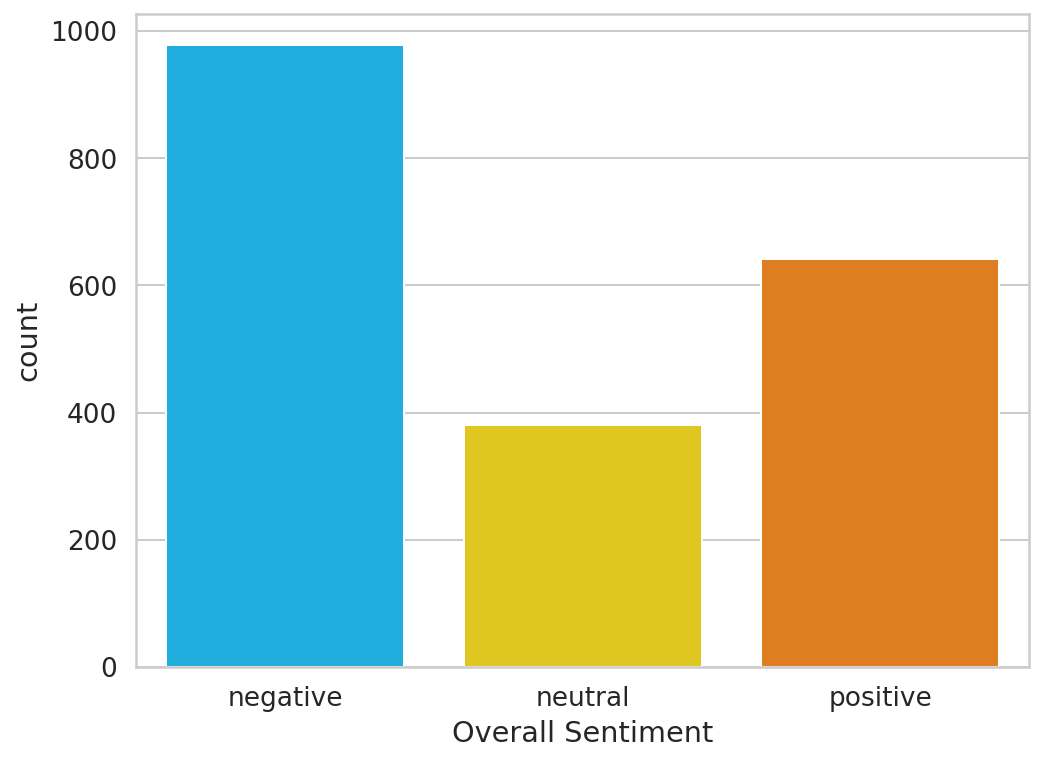

In [ ]:
ax = sns.countplot(df["Overall Sentiment"])
classes = ['negative', 'neutral', 'positive']
ax.set_xticklabels(classes);

## Data Preprocessing

In [ ]:
 tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
sample_txt = 'How is your day going, Jerry? My day is going very well'

In [ ]:
tokens = tokenizer.tokenize(df.Sentence[575])

In [ ]:
tokens

['although',
 'jackson',
 "'",
 's',
 'counsel',
 'did',
 'not',
 'specifically',
 'object',
 'to',
 'the',
 'admission',
 'of',
 'the',
 'confession',
 'initially',
 ',',
 'the',
 'trial',
 'court',
 'indicated',
 'its',
 'awareness',
 'that',
 'jackson',
 "'",
 's',
 'counsel',
 'was',
 'questioning',
 'the',
 'circumstances',
 'under',
 'which',
 'jackson',
 'was',
 'inter',
 '##rogated']

In [ ]:
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(len(token_ids))
print(token_ids)

38
[2348, 4027, 1005, 1055, 9517, 2106, 2025, 4919, 4874, 2000, 1996, 9634, 1997, 1996, 12633, 3322, 1010, 1996, 3979, 2457, 5393, 2049, 7073, 2008, 4027, 1005, 1055, 9517, 2001, 11242, 1996, 6214, 2104, 2029, 4027, 2001, 6970, 26565]


In [ ]:

encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=70,
  truncation=True,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding = 'max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

## Choosing Sequence Length (based on dataset)

In [ ]:
token_lens = []

for txt in df['Sentence']:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


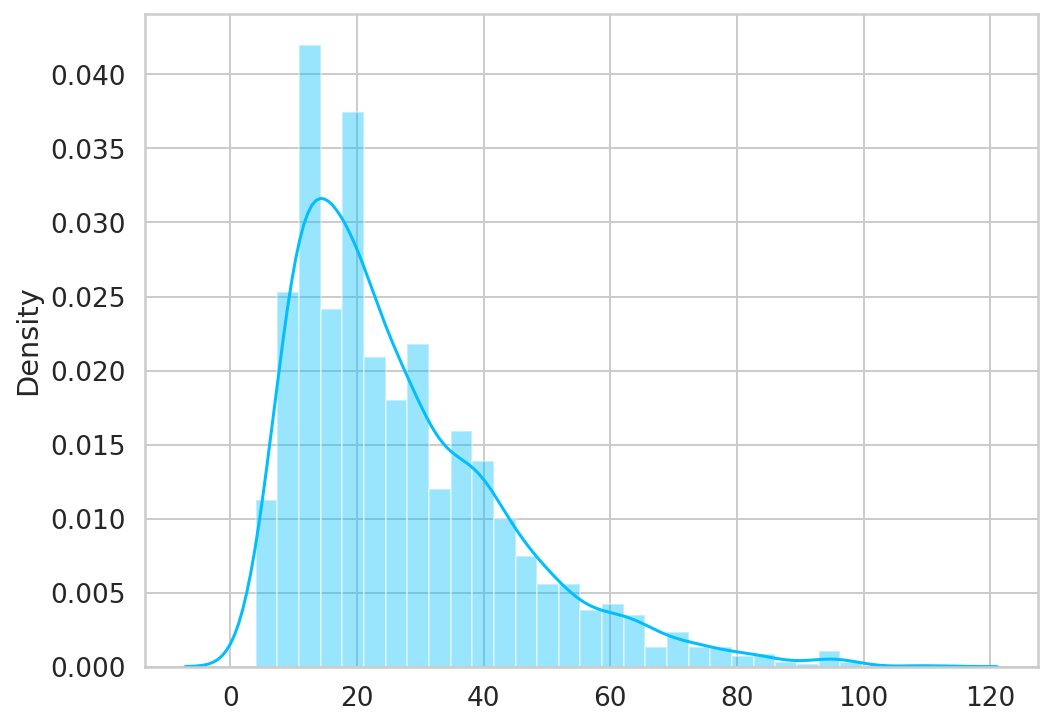

In [ ]:
sns.distplot(token_lens)

In [ ]:
# most of the sentences are under 70, so we make that max length
max_len = 70

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Creating a dataset
Now we will preprocess the actual dataset for putting into ML models in PyTorch and Tensorflow

In [ ]:
class BertTokenizer1(object):

    def __init__(self, text=[]):
        self.text = text

        # For transformers model
        self.model_class, self.tokenizer_class, self.pretrained_weights = (transformers.BertModel, transformers.BertTokenizer, 'bert-base-uncased')

        # Load pretrained model/tokenizer
        self.tokenizer = self.tokenizer_class.from_pretrained(self.pretrained_weights)

        self.model = self.model_class.from_pretrained(self.pretrained_weights)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)

    def get(self):

        df = pd.DataFrame(data={"text":self.text})
        tokenized = df["text"].swifter.apply((lambda x: self.tokenizer.encode(x, add_special_tokens=True)))

        max_len = 0
        for i in tokenized.values:
            if len(i) > max_len:
                max_len = len(i)

        padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

        attention_mask = np.where(padded != 0, 1, 0)
        input_ids = torch.tensor(padded)
        attention_mask = torch.tensor(attention_mask)

        input_ids = input_ids.cuda()
        attention_mask = attention_mask.cuda()

        with torch.no_grad(): last_hidden_states = self.model(input_ids, attention_mask=attention_mask)

        # features = last_hidden_states[0]
        features = last_hidden_states[0][:, 0, :]

        return features

In [ ]:
X = df.Sentence
Y = df['Overall Sentiment']
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [ ]:
ds = BertTokenizer1(text = x_train)
tokens = ds.get()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokens = tokens.cpu().numpy()

In [ ]:
xtest = BertTokenizer1(text = x_test)
tokens_test = xtest.get()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokens_test = tokens_test.cpu().numpy()

Base Machine Learning models with BERT embedding

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree             # tree.DecisionTreeClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm #clf = svm.SVC(decision_function_shape='ovo')
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate

In [ ]:
##### RANDOM FOREST ######
rf = RandomForestClassifier(random_state=42)

# Validate the model's performance using k-fold cross validation

cv_rf = cross_validate (rf, tokens, y_train, cv = 10)
print("Random Forest cross validation accuracy mean score: \n", cv_rf['test_score'].mean())

rf.fit(tokens, y_train)
y_pred_rf = rf.predict(tokens_test)
print('accuracy %s' % accuracy_score(y_pred_rf, y_test))
print(classification_report(y_test, y_pred_rf))

Random Forest cross validation accuracy mean score: 
 0.5942857142857143
accuracy 0.5683333333333334
              precision    recall  f1-score   support

           0       0.58      0.80      0.67       291
           1       0.66      0.50      0.57       121
           2       0.45      0.26      0.33       188

    accuracy                           0.57       600
   macro avg       0.56      0.52      0.52       600
weighted avg       0.55      0.57      0.54       600



In [ ]:
##### LOGISTIC REGRESSION ######
lr_clf = LogisticRegression(max_iter=1500, solver='lbfgs')

# evaluate the accuracy score with cv
cv_log = cross_validate (lr_clf, tokens, y_train, cv = 15)
print("Logistic Regression CV accuracy mean score: \n", cv_log['test_score'].mean())

lr_clf.fit(tokens, y_train)
y_pred_log = lr_clf.predict(tokens_test)
print('accuracy on test set %s' % accuracy_score(y_pred_log, y_test))
print(classification_report(y_test, y_pred_log))

Logistic Regression CV accuracy mean score: 
 0.599916113780218
accuracy on test set 0.6066666666666667
              precision    recall  f1-score   support

           0       0.71      0.65      0.68       291
           1       0.56      0.61      0.58       121
           2       0.50      0.54      0.52       188

    accuracy                           0.61       600
   macro avg       0.59      0.60      0.59       600
weighted avg       0.61      0.61      0.61       600



In [ ]:
##### SVM ######
svm = svm.SVC(decision_function_shape='ovo', probability=True)

# Validate the model's performance using k-fold cross validation

cv_svm = cross_validate (svm, tokens, y_train, cv = 10)
print("SVM CV accuracy mean score: \n", cv_svm['test_score'].mean())

svm.fit(tokens, y_train)
y_pred_svm = svm.predict(tokens_test)
print('accuracy on test set %s' % accuracy_score(y_pred_svm, y_test))
print(classification_report(y_test, y_pred_svm))

SVM CV accuracy mean score: 
 0.5764285714285713
accuracy on test set 0.58
              precision    recall  f1-score   support

           0       0.59      0.85      0.69       291
           1       0.55      0.38      0.45       121
           2       0.58      0.29      0.38       188

    accuracy                           0.58       600
   macro avg       0.57      0.51      0.51       600
weighted avg       0.58      0.58      0.55       600



In [ ]:
##### Decision Tree ######
tree = tree.DecisionTreeClassifier()

# Validate the model's performance using k-fold cross validation

cv_tree = cross_validate(tree, tokens, y_train, cv = 10)
print("Decision Tree CV accuracy mean score: \n", cv_tree['test_score'].mean())

tree.fit(tokens, y_train)
y_pred_tree = tree.predict(tokens_test)
print('accuracy on test set %s' % accuracy_score(y_pred_tree, y_test))
print(classification_report(y_test, y_pred_tree))

Decision Tree CV accuracy mean score: 
 0.49285714285714277
accuracy on test set 0.52
              precision    recall  f1-score   support

           0       0.58      0.55      0.57       291
           1       0.53      0.54      0.53       121
           2       0.43      0.46      0.44       188

    accuracy                           0.52       600
   macro avg       0.51      0.52      0.51       600
weighted avg       0.52      0.52      0.52       600

